# ImageAnnotationChallenge

## Overview : 概要

### Project target : プロジェクト目標

- 普通のECサイトにおける検索機能について､改善方法を検討する
- 画像認識によるタグ付けの開発を優先する
- メンバーも実際のプロジェクト経験をもらいつつ､デモプロジェクトの開発と記事を作成できるまで頑張る

In English:
- Consider the ways how to improve search function on e-commerce site.
- Prioritize the development of tagging by image recognition.
- The members will do our best until creating an article and developing demo project, gaining project experience.


### Study scope : 学習範囲

* Note記事を書く
* 画像認識によるタグ付けを優先して開発する
* 日本語･英語両方タグ付けできるようにする

In English:

* Write a note article
* Develop tagging system by image recognition in priority
* The system becomes able to tag  in Japanese and English


### Repository

* [TOP](https://github.com/ryu-i-engineer/ImageAnnotationChallenge)
* [Projects](https://github.com/ryu-i-engineer/ImageAnnotationChallenge/projects/2)

## Reference

- https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub
- https://www.tensorflow.org/tutorials/images/segmentation

### About Transfer learning

#### Domain problem

- [転移学習：機械学習の次のフロンティアへの招待](https://qiita.com/icoxfog417/items/48cbf087dd22f1f8c6f4#%E8%BB%A2%E7%A7%BB%E5%AD%A6%E7%BF%92%E3%81%AE%E5%8F%96%E3%82%8A%E7%B5%84%E3%82%80%E5%95%8F%E9%A1%8C)

## Dataset

### Using web scraping

From here.
- https://jp.misumi-ec.com/vona2/mech_screw/M3303000000/?rid=c21_top_4_M3303000000

In [1]:
import os
import seaborn as sns
import pandas as pd

misumi_dataset_path = "./inputs/misumi_dataset_cleansing"

label_names = []
label_file_counts = []

for dir_name in os.listdir(misumi_dataset_path):
    label_names.append(dir_name)
    label_file_counts.append(len([filename for filename in os.listdir(os.path.join(misumi_dataset_path, dir_name)) if os.path.isfile(os.path.join(misumi_dataset_path, dir_name, filename))]))
    

In [2]:
d = {'Labels' : label_names, 'File counts': label_file_counts}
misumi_df = pd.DataFrame(d)
misumi_df.describe()

,File counts
count,134.000000
mean,87.089552
std,170.999559
min,2.000000
25%,17.000000
50%,40.000000
75%,86.750000
max,1491.000000


### Dummy data

- 3D
- CAD
- Items should not be there.
- Utilities something like "Accessories" and "Components"

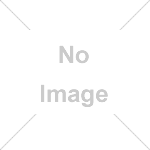
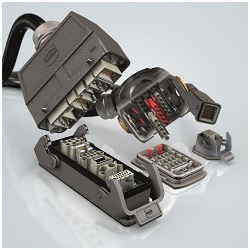
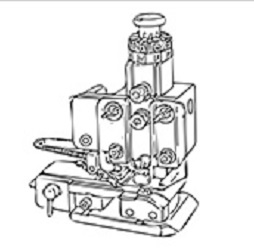
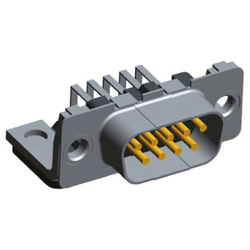

## Codes

### Using TF Hub for Transfer learning

#### Prepare

In [3]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

import datetime

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15465943476227135696
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4853137408
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6780786573594206246
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [6]:
# Download classification
# classifier_url = "https://tfhub.dev/google/imagenet/resnet_v2_152/classification/5" # ResNet-152
# classifier_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/classification/2" # EfficientNet V2

mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"

# classifier_model = mobilenet_v2

In [7]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(mobilenet_v2, input_shape=IMAGE_SHAPE+(3,))
])

#### Execute one image file

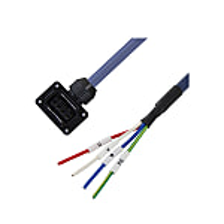

In [8]:
import numpy as np
import PIL.Image as Image

# grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
# grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper = Image.open("./inputs/misumi_dataset/ac_servo_motor_cables/000001.jpg").resize(IMAGE_SHAPE)
grace_hopper

In [9]:
# Get batch dimension and input image to model.
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [10]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [11]:
predicted_class = tf.math.argmax(result[0], axis=-1)
predicted_class

<tf.Tensor: shape=(), dtype=int64, numpy=793>

#### Decode the predict result

In [12]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

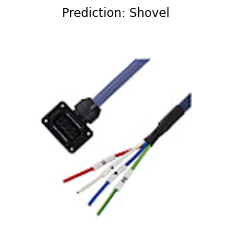

In [13]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

In [14]:
# data_root = tf.keras.utils.get_file(
#   'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
#    untar=True)

data_root = "./inputs/misumi_dataset_cleansing"

In [15]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 11670 files belonging to 134 classes.
Using 9336 files for training.
Found 11670 files belonging to 134 classes.
Using 2334 files for validation.


In [16]:
class_names = np.array(train_ds.class_names)
print(f"This datasets has {len(class_names)} classes.")

This datasets has 134 classes.


In [17]:
# add normalization layer
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

In [18]:
# avoid I/O blocking issues
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


#### Download headless model

In [20]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
effienct_v2 = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_s/classification/2"

feature_extractor_model = effienct_v2

In [21]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False
)

In [22]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1000)


#### Attach a classification head

In [23]:
num_classes = len(class_names)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SHAPE+(3,)),
    feature_extractor_layer,
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(num_classes)
])
model.build((None,)+IMAGE_SHAPE+(3,))

In [24]:
predictions = model(image_batch)
predictions.shape

TensorShape([32, 134])

#### Train model

In [25]:
model.compile(
  optimizer=tf.keras.optimizers.Nadam(learning_rate=0.0005),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1000)              21612360  
_________________________________________________________________
dropout (Dropout)            (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 134)               134134    
Total params: 21,746,494
Trainable params: 134,134
Non-trainable params: 21,612,360
_________________________________________________________________


In [26]:
NUM_EPOCHS = 50

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.001, patience=3
)

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=[early_stopping])

Epoch 1/50
292/292 [==============================] - 109s 336ms/step - loss: 2.4873 - acc: 0.4388 - val_loss: 1.3484 - val_acc: 0.6525
Epoch 2/50
292/292 [==============================] - 77s 265ms/step - loss: 1.2475 - acc: 0.6583 - val_loss: 1.0645 - val_acc: 0.7262
Epoch 3/50
292/292 [==============================] - 77s 264ms/step - loss: 0.9360 - acc: 0.7381 - val_loss: 0.9616 - val_acc: 0.7536
Epoch 4/50
292/292 [==============================] - 77s 265ms/step - loss: 0.7844 - acc: 0.7729 - val_loss: 0.9199 - val_acc: 0.7588
Epoch 5/50
292/292 [==============================] - 77s 264ms/step - loss: 0.6846 - acc: 0.8025 - val_loss: 0.8913 - val_acc: 0.7665
Epoch 6/50
292/292 [==============================] - 78s 266ms/step - loss: 0.6151 - acc: 0.8157 - val_loss: 0.8659 - val_acc: 0.7772
Epoch 7/50
292/292 [==============================] - 77s 265ms/step - loss: 0.5640 - acc: 0.8307 - val_loss: 0.8598 - val_acc: 0.7793
Epoch 8/50
292/292 [==============================] - 

In [27]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

['wing_screw' 'wiring_connector_circular' 'hex_socket_head_cap'
 'cableBushing_clips' 'strippers_reamers_shoulder_bolts'
 'heat_shrink_tubing' 'wiring_rectangular_connectors' 'space_saving_bolts'
 'nuts_non-metal' 'comAV_usb_accessories' 'cableBushing_stickers'
 'lan_cable_connector_tools' 'captive_washer_screws'
 'wiring_connector_circular' 'wiring_connector_circular'
 'captive_washer_screws' 'wiring_control_instrumentation' 'hex_bolts'
 'wiring_nylon_connectors' 'tamper_resistant_screws'
 'wiring_nylon_connectors' 'wiring_nylon_connectors'
 'wiring_nylon_connectors' 'self_tapping_screws' 'heat_shrink_tubing'
 'inserts_tools_for_threaded' 'nuts_lock' 'wiring_connector_circular'
 'wiring_control_instrumentation' 'wiring_nylon_connectors'
 'wiring_connector_circular' 'wiring_nylon_connectors']


#### Visualization of model training history

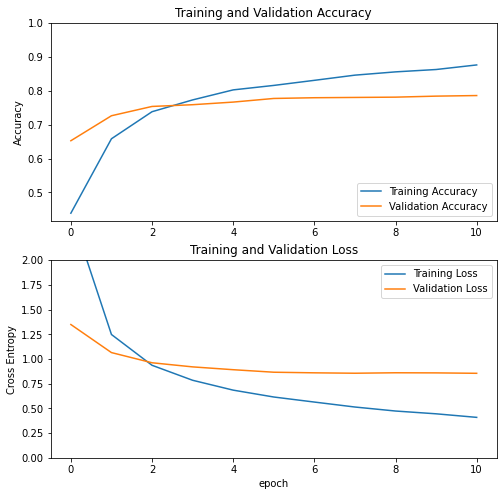

In [28]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#### Result

In [29]:
print(predicted_id)
print(labels_batch)

tf.Tensor(
[106 117  47   2  97  43 129  94  71  21   3  53   9 117 117   9 121  44
 127  98 127 127 127  82  43  51  70 117 121 127 117 127], shape=(32,), dtype=int64)
tf.Tensor(
[106 117  47   2  97  43 129  33  71  21   3  53   9 117  12   9 121  44
 127  98 127 127 127  82  43  51  70 117 121 127 117 127], shape=(32,), dtype=int32)


In [38]:
class_names[33]

'cross_recessed_bolts'

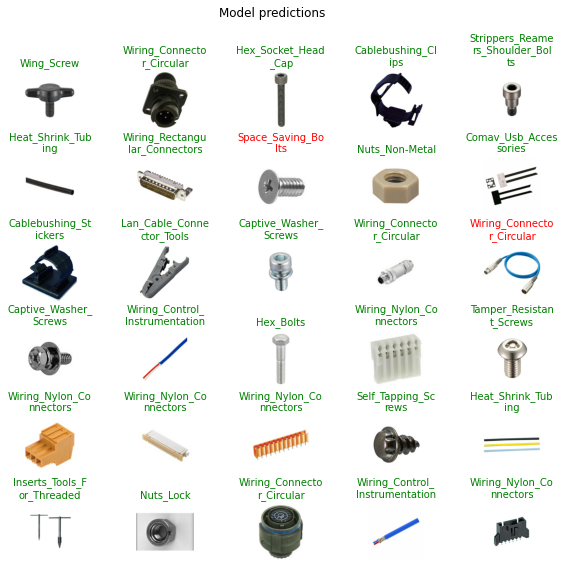

In [31]:
from textwrap import wrap
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n].numpy() == labels_batch[n].numpy() else "red"
  plt.title('\n'.join(wrap(predicted_label_batch[n].title(), 15)), color=color, fontsize=10)
  plt.axis('off')
_ = plt.suptitle("Model predictions")

#### Export model

In [32]:
from datetime import date

export_path = f"./models/{date.today().isoformat()}_{str(int(time.time()))}"
model.save(export_path, save_format='tf')

export_path

INFO:tensorflow:Assets written to: ./models/2021-10-20_1634714161\assets


INFO:tensorflow:Assets written to: ./models/2021-10-20_1634714161\assets


'./models/2021-10-20_1634714161'

In [33]:
# import os
# # os.listdir("./models/")
# print(len(next(os.walk('./models/'))[1]))

In [34]:
# reloaded = tf.keras.models.load_model(export_path)

In [35]:
# result_batch = model.predict(image_batch)
# reloaded_result_batch = reloaded.predict(image_batch)

In [36]:
# abs(reloaded_result_batch - result_batch).max()